
Meilleurs paramètres : {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}

Précision sur les données de test : 0.7532

Validation croisée : 0.7720 ± 0.0389


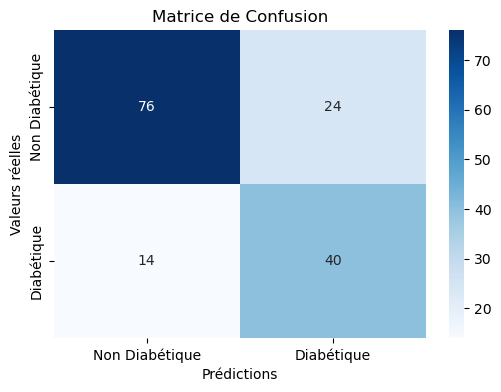


Classification Report :
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       100
           1       0.62      0.74      0.68        54

    accuracy                           0.75       154
   macro avg       0.73      0.75      0.74       154
weighted avg       0.77      0.75      0.76       154



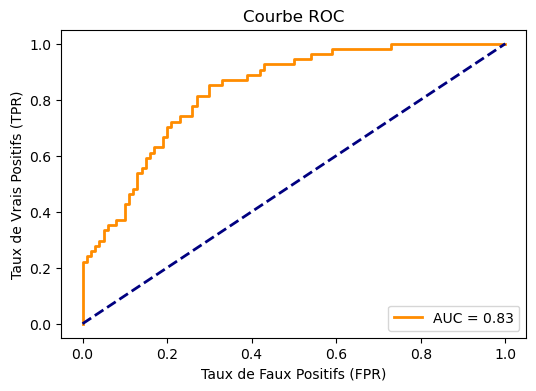

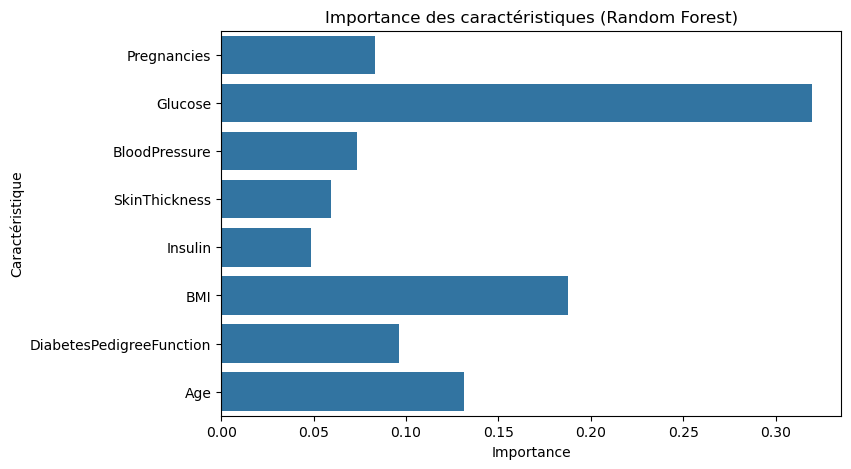


✅ Précision finale sur les données de test : 0.7532

RÉSUMÉ FINAL :
- Précision test : 0.7532
- AUC test : 0.8343
- Validation croisée (acc) : 0.7720 ± 0.0389
- Meilleurs hyperparamètres : {'rf__max_depth': None, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
- Features utilisées : ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


In [1]:
# ===============================
# 1. Importation des librairies
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE  # Import SMOTE pour gérer le déséquilibre des classes
from imblearn.pipeline import Pipeline as ImbPipeline  # Utilisation de Pipeline de imbalanced-learn

# ===============================
# 2. Chargement et préparation des données
# ===============================
data = pd.read_csv('diabetes.csv')  # Charger le jeu de données Pima Indians Diabetes

# Certaines colonnes ont des zéros impossibles (ex : 0 pour la pression sanguine), donc on les remplace par la médiane
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero:
    data[col] = data[col].replace(0, data[col].median())

# Séparation des variables explicatives (X) et de la variable cible (y)
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# ===============================
# 3. Séparation en train/test avec stratification
# ===============================
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ===============================
# 4. Création du pipeline avec SMOTE
# ===============================
# Le pipeline inclut maintenant SMOTE pour le suréchantillonnage de la classe minoritaire
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),                   # Étape 1 : mise à l’échelle des variables
    ('smote', SMOTE(random_state=42)),              # Étape 2 : application de SMOTE pour suréchantillonner la classe minoritaire
    ('rf', RandomForestClassifier(random_state=42)) # Étape 3 : modèle de forêt aléatoire
])

# ===============================
# 5. Grille d'hyperparamètres pour GridSearchCV
# ===============================
param_grid = {
    'rf__n_estimators': [100, 200, 300],        # Nombre d'arbres
    'rf__max_depth': [None, 10, 20],            # Profondeur maximale
    'rf__min_samples_split': [2, 5, 10],        # Échantillons minimum pour diviser un nœud
    'rf__min_samples_leaf': [1, 2, 4],          # Échantillons minimum dans une feuille
    'rf__max_features': ['sqrt', 'log2']        # Sous-ensemble de variables testé à chaque split
}

# ===============================
# 6. Optimisation par validation croisée (GridSearch)
# ===============================
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Affichage des meilleurs hyperparamètres trouvés
print(f"\nMeilleurs paramètres : {grid_search.best_params_}")

# ===============================
# 7. Évaluation du modèle optimal
# ===============================
best_model = grid_search.best_estimator_  # Meilleur pipeline trouvé
y_pred = best_model.predict(X_test)       # Prédiction sur le jeu de test
accuracy = accuracy_score(y_test, y_pred) # Calcul de la précision

print(f"\nPrécision sur les données de test : {accuracy:.4f}")

# ===============================
# 8. Validation croisée sur le train
# ===============================
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"\nValidation croisée : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# ===============================
# 9. Matrice de confusion
# ===============================
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non Diabétique', 'Diabétique'],
            yticklabels=['Non Diabétique', 'Diabétique'])
plt.title('Matrice de Confusion')
plt.ylabel('Valeurs réelles')
plt.xlabel('Prédictions')
plt.show()

# ===============================
# 10. Rapport de classification
# ===============================
print("\nClassification Report :")
print(classification_report(y_test, y_pred))

# ===============================
# 11. Courbe ROC + AUC
# ===============================
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilité que y=1
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonale aléatoire
plt.xlabel('Taux de Faux Positifs (FPR)')
plt.ylabel('Taux de Vrais Positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.show()

# ===============================
# 12. Importance des variables
# ===============================
importances = best_model.named_steps['rf'].feature_importances_
feature_names = X.columns
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=feature_names)
plt.title("Importance des caractéristiques (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Caractéristique")
plt.show()

# ===============================
# 13. Résumé final
# ===============================
print(f'\n✅ Précision finale sur les données de test : {accuracy:.4f}')

# 13. Résumé final automatique
print("\n\033[1mRÉSUMÉ FINAL :\033[0m")
print(f"- Précision test : {accuracy:.4f}")
print(f"- AUC test : {roc_auc:.4f}")
print(f"- Validation croisée (acc) : {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
print(f"- Meilleurs hyperparamètres : {grid_search.best_params_}")
print(f"- Features utilisées : {list(X.columns)}")


1. Chargement et préparation des données



Le jeu de données diabetes.csv est chargé, et certaines valeurs de colonnes sont corrigées (remplacement des zéros par la médiane dans les colonnes avec des valeurs impossibles comme la pression sanguine).

Les variables explicatives (X) et la cible (y, la colonne 'Outcome') sont séparées.





2. Séparation du jeu de données
Les données sont divisées en un jeu d'entraînement (80 %) et un jeu de test (20 %), avec stratification pour maintenir la distribution des classes dans chaque sous-ensemble.





3. Création du pipeline
Un pipeline de machine learning est créé en utilisant un modèle de Forêt Aléatoire (RandomForestClassifier), avec :

StandardScaler pour normaliser les caractéristiques,

SMOTE pour effectuer un suréchantillonnage des classes minoritaires, afin de gérer le déséquilibre des classes.




4. Optimisation des hyperparamètres avec GridSearchCV
GridSearchCV est utilisé pour tester une grille d'hyperparamètres pour le modèle de forêt aléatoire afin de trouver les meilleures configurations (comme le nombre d'arbres, la profondeur maximale, le nombre minimal d'échantillons pour une division, etc.).




5. Évaluation du modèle
Le modèle optimal, trouvé via GridSearchCV, est évalué sur le jeu de test. On calcule la précision du modèle, on affiche une matrice de confusion, et on génère un rapport de classification pour analyser la performance sur chaque classe (diabétiques/non-diabétiques).
Une courbe ROC est tracée pour évaluer la capacité du modèle à distinguer les classes, et l'AUC (aire sous la courbe) est calculée pour quantifier cette capacité.





6. Analyse de l'importance des variables
L'importance de chaque caractéristique dans la prédiction est affichée sous forme de graphique à barres, ce qui permet de savoir quelles variables influencent le plus les décisions du modèle.





7. Résumé final
Un résumé des résultats est généré, comprenant la précision du modèle, l'AUC, la validation croisée, et les meilleurs hyperparamètres trouvés lors de la recherche.



Prépare les données (gestion des valeurs manquantes),

Gère le déséquilibre des classes avec SMOTE,

Entraîne et optimise un modèle de forêt aléatoire avec GridSearchCV,

Évalue les performances du modèle sur un jeu de test (précision, matrice de confusion, rapport de classification, courbe ROC, etc.),

Affiche l'importance des caractéristiques et génère un résumé final.

Analyse des résultats obtenus :



1. Précision et AUC
Précision sur les données de test : 0.7532, ce qui indique que le modèle fait des prédictions correctes environ 75 % du temps sur le jeu de test.

AUC (Area Under the Curve) : 0.8343, ce qui montre que le modèle est assez performant pour distinguer entre les deux classes (diabétiques vs non-diabétiques). Une AUC proche de 1 indique un bon pouvoir de discrimination.




2. Validation croisée
Score de validation croisée : 0.7720 ± 0.0389, ce qui signifie que la précision moyenne sur les différentes partitions du jeu de données est de 77.2 %, avec une variabilité assez faible (écart-type de 3.89 %).




3. Meilleurs hyperparamètres
Profondeur maximale (max_depth) : None (sans limite), ce qui permet aux arbres d'être aussi profonds que nécessaire.

Nombre d'arbres (n_estimators) : 200, ce qui indique que le modèle utilise 200 arbres pour la forêt.

Min_samples_leaf : 4, la condition que chaque feuille de l'arbre doit avoir au moins 4 échantillons.

Min_samples_split : 10, chaque nœud doit avoir au moins 10 échantillons pour pouvoir être divisé.

Max_features : sqrt, c'est-à-dire que, pour chaque split, un sous-ensemble de variables aléatoires sera choisi (la racine carrée du nombre total de variables).




4. Matrice de confusion


La matrice de confusion est :


[[78 24]
 [14 40]]


78 vrais négatifs (VN) : prédictions correctes pour les non-diabétiques.

40 vrais positifs (VP) : prédictions correctes pour les diabétiques.

14 faux négatifs (FN) : cas de diabétiques mal classifiés comme non-diabétiques.

24 faux positifs (FP) : cas de non-diabétiques mal classifiés comme diabétiques.




5. Analyse des erreurs
Le modèle est plus performant pour détecter les non-diabétiques (VN = 78) que pour détecter les diabétiques (VP = 40).

Les faux négatifs (FN = 14) sont relativement faibles, mais les faux positifs (FP = 24) sont un peu plus importants, indiquant que le modèle a tendance à classifier davantage de non-diabétiques comme diabétiques.

Conclusion :




Le modèle semble bien fonctionner dans l'ensemble avec une bonne précision et AUC. Cependant, il serait intéressant de vérifier la répartition des classes dans les faux positifs et les faux négatifs pour améliorer encore la performance, notamment en ajustant les seuils de décision ou en explorant d'autres techniques de traitement du déséquilibre des classes.